# Estimer une probabilité de dépassement de seuil - Application au cas de la poutre en flexion


## Déviation verticale d'une poutre encastrée

Nous considérons une poutre encastrée définie par son module de Young $E$, sa longueur $L$ et son moment d'inertie $I$. Une extrémité est encastrée dans un mur et nous appliquons une charge $F$ à l'autre extrémité de la poutre, ce qui entraîne une déviation verticale $Y$, également nommée « flèche » en mécanique.

Nous analysons la déviation verticale produite par un enfant sur un plongeoir. Nous considérons un enfant dont le poids génère une force approximativement égale à 300 N (c'est-à-dire environ 30 kg). En raison des incertitudes sur le poids de la personne, nous considérons que la force est une variable aléatoire. La longueur du plongeoir est comprise entre 2,5 m et 2,6 m. Le module de Young est incertain et compris entre 65 et 75 GPa (c'est-à-dire entre $65 \times 10^9$ et $75 \times 10^9$ Pascals), ce qui correspond à de la fibre de verre, un matériau souvent utilisé pour les plongeoirs. Les incertitudes liées à la production du matériau sont prises en compte dans le module de Young et le moment d'inertie du plongeoir.

<img src="poutre.png" width="200">

**Figure 1.** Déviation verticale $Y$ de la poutre encastrée de longueur $L$.

## Entrées

- $E$ : Module de Young (en Pa),
- $F$ : Charge (en N),
- $L$ : Longueur de la poutre (en m),
- $I$ : Moment d'inertie (en $\mathrm{m}^4$).

| Variable | Distribution                                                                      |
| -------- | --------------------------------------------------------------------------------- |
| E        | Beta(alpha = 0.9, beta = 3.5, a = $65 \times 10^9$, $b = 75 \times 10^9$)         |
| F        | Lognormal($\mu_F=300 $, $\sigma_F=30$, $\gamma$=0)                                   |
| L        | Uniform(min=2.5, max= 2.6)                                                        |
| I        | Beta(alpha = 2.5, beta = 4.0, a = $1.3 \times 10^{-7}$, b = $1.7 \times 10^{-7}$) |

**Tableau 1.** Lois marginales des variables $E$, $F$, $L$ et $I$.

Dans le tableau précédent, $\mu_F = \mathbb{E}[F]$ et $\sigma_F = \sqrt{\operatorname{Var}(F)}$ désignent la moyenne et l'écart-type de $F$. Les variables d'entrée sont supposées indépendantes.

**Remarque.** La variable $F$ est de loi Log-Normale. Il serait possible de paramétrer cette variable aléatoire en spécifiant la moyenne et l'écart-type de la variable gaussienne sous-jacente. Ce n'est toutefois pas ce qui est réalisé ici : nous spécifions la moyenne et l'écart-type de la variable $F$ elle-même. C'est la raison pour laquelle nous utiliserons par la suite la classe `LogNormalMuSigma`.

**Remarque.** Les paramètres de forme de la loi Beta ($\alpha=0.9$ et $\beta=3.5$) modélisent une asymétrie marquée vers la borne inférieure, représentative d'un biais de fabrication tendant vers la spécification minimale du matériau. 

## Sortie d'intérêt

Le déplacement vertical à l'extrémité libre de la poutre encastrée est :
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}.
$$

**Quantité d'intérêt**

On considère que la défaillance se produit lorsque la flèche de la poutre est supérieure à 0.21 m :
$$
Y \geq 0.21 \textrm{ (m)}
$$
On s'intéresse à la probabilité :
$$
p_f = \mathbb{P}(Y \geq 0.21).
$$

**Valeur de référence**

Avec un échantillon de Monte-Carlo de taille 1 200 000, on obtient :
$$
\widehat{p}_f = 0.034700.
$$
L'intervalle de confiance à 95 % de la probabilité de défaillance est :
$$
\mathbb{P}([0.03357,0.03583]\ni p_f) = 0.95.
$$


## Rappels mathématiques

Soit $\left\{\boldsymbol{x}^{(j)} \in \mathbb{R}^d\right\}_{1 \leq j \leq n}$ un échantillon Monte-Carlo simple du vecteur aléatoire $\boldsymbol{X}$, où $n$ est la taille de l'échantillon. Soit $\left\{y^{(j)} \in \mathbb{R}^d\right\}_{1 \leq n}$ l'échantillon des sorties correspondantes, où :
$$
y^{(j)} = g\left(\boldsymbol{x}^{(j)}\right)
$$
pour $1 \leq j \leq n$. 
Soit $b^{(j)}$ la variable définie par :
$$
b^{(j)} = 
\begin{cases}
1 & \textrm{ si } y^{(j)} > s, \\
0 & \textrm{ sinon.}
\end{cases}
$$
Alors l'estimateur Monte-Carlo simple est :
$$
\widehat{p}_f = \frac{1}{n} \sum_{j = 1}^n b^{(j)}.
$$
La loi asymptotique de cet estimateur est :
$$
\mathcal{N}\left(p_f, \frac{p_f (1 - p_f)}{n}\right).
$$
Par définition, le coefficient de variation de l'estimateur est :
$$
\operatorname{CV}\left(\widehat{p}_f\right)
= \frac{\sqrt{\operatorname{Var}\left(\widehat{p}_f\right)}}{\left|\mathbb{E}\left[\widehat{p}_f\right]\right|}.
$$
On obtient :
$$
\operatorname{CV}\left(\widehat{p}_f\right)
= \sqrt{\frac{1 - p_f}{n p_f}}
$$
si $p_f > 0$.


# Model definition

In [1]:
import openturns as ot
import openturns.viewer as otv
import math
import tabulate

In [2]:
distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
distributionL = ot.Uniform(2.50, 2.60)  # in m
distributionL.setDescription(["L"])
distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # in m^4
distributionI.setDescription(["I"])

X = ot.JointDistribution([distributionE, distributionF, distributionL, distributionI])

In [3]:
g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F * L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (m)"])

Enfin, nous définissons le vecteur aléatoire de sortie.

In [4]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (m)"])

Définit le seuil qui mène à l'évènement redouté.

In [5]:
seuilStandard = 0.21

## Par Monte-Carlo simple avec un budget fixé

La manière la plus simple de faire une telle étude consiste à fixer le nombre de simulations à l'avance. En d'autres termes, on fixe $n$ et on génère un échantillon de la variable de sortie $Y$ de taille $n$. C'est la méthode « classique ».

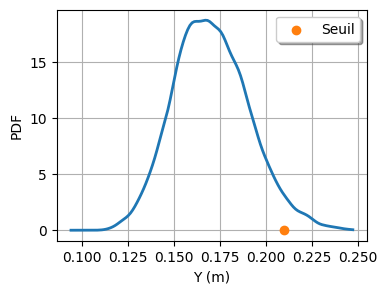

In [6]:
sampleSizeMCSimple = 10000
ySample = Y.getSample(sampleSizeMCSimple)  # ⚠️ Peut être long
# Trace une estimation de la densité de probabilité
graph = ot.KernelSmoothing().build(ySample).drawPDF()
graph.setLegends([""])
cloud = ot.Cloud([seuilStandard], [0.0])
cloud.setPointStyle("o")
cloud.setLegend("Seuil")
graph.add(cloud)
graph.setXTitle("Y (m)")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

La probabilité recherchée peut être calculée en évaluant la fonction de répartition complémentaire de l'échantillon car $\mathbb{P}(Y > s) = 1 - \mathbb{P}(Y \leq s)$.

In [7]:
pfHatMCSimple = ySample.computeEmpiricalCDF([seuilStandard], True)
pfHatMCSimple

0.0357

La fonction suivante permet de calculer l'écart-type de la distribution gaussienne asymptotique de l'estimateur de la probabilité de dépassement.

In [8]:
def computePfStandardDeviation(pfHat, n):
    """
    Calcule l'écart-type de l'estimateur de la probabilité de défaillance.

    Cette fonction évalue l'écart-type de l'estimateur de Monte-Carlo
    pour une probabilité, en utilisant la formule de l'écart-type d'une
    proportion empirique.

    Parameters
    ----------
    pfHat : float
        L'estimation de la probabilité de défaillance.
    n : int
        La taille de l'échantillon.

    Returns
    -------
    sigmaPf : float
        L'écart-type de l'estimateur.
    """

    sigmaPf = math.sqrt(pfHat * (1 - pfHat) / n)
    return sigmaPf

La fonction suivante calcule la distribution asymptotique de l'estimateur ainsi qu'un intervalle de confiance de la probabilité de dépassement de seuil.

In [9]:
def computeConfidenceInterval(pfHat, n, confidenceLevel=0.95):
    """
    Calcule l'intervalle de confiance asymptotique d'une probabilité.

    Cette fonction construit un intervalle de confiance bilatéral pour une
    probabilité estimée par simulation de Monte-Carlo, en utilisant
    l'approximation normale (intervalle de Wald).

    Parameters
    ----------
    pfHat : float
        L'estimation de la probabilité de défaillance.
    n : int
        La taille de l'échantillon utilisé pour l'estimation.
    confidenceLevel : float, optional
        Le niveau de confiance (probabilité de couverture) de l'intervalle.
        La valeur par défaut est 0.95.

    Returns
    -------
    pfDistribution : ot.Normal
        La distribution asymptotique de l'estimateur (loi Normale).
    lowerBound : float
        La borne inférieure de l'intervalle de confiance.
    upperBound : float
        La borne supérieure de l'intervalle de confiance.
    """
    sigmaPf = computePfStandardDeviation(pfHat, n)
    pfDistribution = ot.Normal(pfHat, sigmaPf)
    bounds = pfDistribution.computeBilateralConfidenceInterval(confidenceLevel)
    lowerBound = bounds.getLowerBound()[0]
    upperBound = bounds.getUpperBound()[0]
    return pfDistribution, lowerBound, upperBound

On peut calculer l'écart-type de la loi gaussienne asymptotique associée à l'estimateur empirique.

In [10]:
sigmaPf = computePfStandardDeviation(pfHatMCSimple, sampleSizeMCSimple)
sigmaPf

0.001855411275162464

On peut ensuite définir la loi gaussienne en utilisant la classe `Normal`.

In [11]:
confidenceLevel = 0.95
pfHatDistribution = ot.Normal(pfHatMCSimple, sigmaPf)
pfHatDistribution

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0.0357] sigma=class=Point name=Unnamed dimension=1 values=[0.00185541] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

La variable `bounds` est un `Interval`. Pour récupérer ses bornes, on peut utiliser `getLowerBound` et `getUpperBound`.

In [12]:
confidenceLevel = 0.95
pfDistribution, lowerBoundMCSimple, upperBoundMCSimple = computeConfidenceInterval(
    pfHatMCSimple, sampleSizeMCSimple, confidenceLevel
)
print(
    f"{(confidenceLevel) * 100:.2f}% confidence interval = "
    f"[{lowerBoundMCSimple:f},{upperBoundMCSimple:f}]"
)

95.00% confidence interval = [0.032063,0.039337]


La cellule suivante calcule la distribution de l'estimateur.

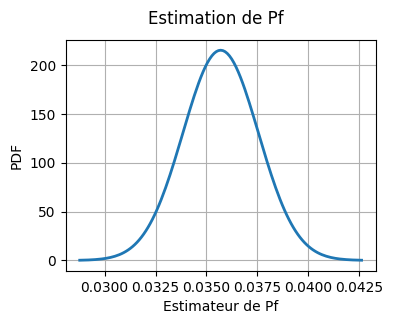

In [13]:
graph = pfDistribution.drawPDF()
graph.setXTitle("Estimateur de Pf")
graph.setTitle("Estimation de Pf")
graph.setLegends([""])
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Par Monte-Carlo avec un algorithme itératif

La classe `ProbabilitySimulationAlgorithm` permet de calculer une probabilité avec une précision fixée par l'utilisateur en utilisant la taille d'échantillon $n$ la plus petite possible. C'est la méthode « moderne ».

Il y a deux boucles imbriquées : la boucle externe sur `maximumOuterSampling` et la boucle interne sur `blockSize`.
L'implémentation suivante empêcherait toute parallélisation car les évaluations de la fonction `g` sont faites une par une :
```python
for i in range(maximumOuterSampling):
    for j in range(blockSize):
        sample = Y.getSample(1)
```
L'implémentation suivante permet la parallélisation car on peut évaluer plusieurs points à la fois à l'intérieur d'un bloc :
```python
for i in range(maximumOuterSampling):
    sample = Y.getSample(blockSize)
```
En effet, la méthode `getSample()` est parallèle si la fonction `g` est elle-même parallèle. 

In [14]:
myEvent = ot.ThresholdEvent(Y, ot.Greater(), seuilStandard)

blockSize = 1000
experiment = ot.MonteCarloExperiment()
myAlgo = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
myAlgo.setMaximumOuterSampling(10000)
myAlgo.setBlockSize(blockSize)
myAlgo.setMaximumCoefficientOfVariation(0.01)

myAlgo.run()

result = myAlgo.getResult()

La méthode `getOuterSampling` permet d'obtenir le nombre d'itérations dans la boucle externe. 

In [15]:
outerSampling = result.getOuterSampling()
print(f"outerSampling = {outerSampling}")
functionCalls = blockSize * outerSampling
print(f"functionCalls = {functionCalls}")
pfHatIterative = result.getProbabilityEstimate()
print(f"pfHat = {pfHatIterative}")

outerSampling = 276
functionCalls = 276000
pfHat = 0.03501086956521739


On peut ensuite calculer un intervalle de confiance de la probabilité.

In [16]:
confidenceLevel = 0.95  # Le niveau de confiance de l'intervalle
pfHatDistribution = result.getProbabilityDistribution()
pfHatInterval = pfHatDistribution.computeBilateralConfidenceInterval(confidenceLevel)
lowerBoundIterative = pfHatInterval.getLowerBound()[0]
upperBoundIterative = pfHatInterval.getUpperBound()[0]
print(
    f"{confidenceLevel * 100:.2f}% confidence interval = "
    f"[{lowerBoundIterative:f}, {upperBoundIterative:f}]"
)


95.00% confidence interval = [0.034325, 0.035697]


La méthode `getProbabilityDistribution()` retourne la distribution de l'estimateur de $p_f$.

In [17]:
pfHatDistribution = result.getProbabilityDistribution()
pfHatDistribution

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0.0350109] sigma=class=Point name=Unnamed dimension=1 values=[0.000350046] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

On peut tracer la convergence de l'algorithme.

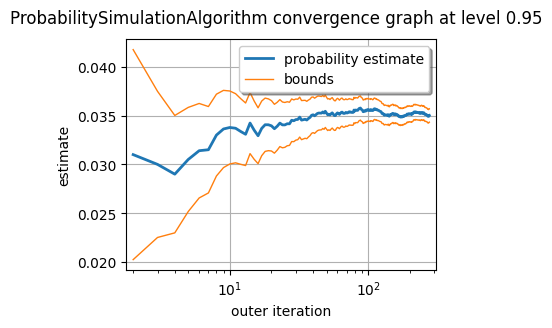

In [18]:
graph = myAlgo.drawProbabilityConvergence()
graph.setLogScale(ot.GraphImplementation.LOGX)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Synthèse

La table suivante présente les résultats. 

In [19]:
data = []
data.append(["Monte-Carlo simple", f"[{lowerBoundMCSimple:.6f}, {upperBoundMCSimple:.6f}]", sampleSizeMCSimple])
data.append(["Monte-Carlo itératif", f"[{lowerBoundIterative:.6f}, {upperBoundIterative:.6f}]", functionCalls])
tabulate.tabulate(data, tablefmt="html", headers=["Méthode", "pfHat", "n"])

Méthode,pfHat,n
Monte-Carlo simple,"[0.032063, 0.039337]",10000
Monte-Carlo itératif,"[0.034325, 0.035697]",276000


On observe que 10 000 calculs ne sont pas suffisants pour obtenir un chiffre significatif, même si on obtient l'ordre de grandeur de la probabilité: il faut davantage de simulations.

Il y a plusieurs méthodes pour améliorer la situation, en particulier la méthode FORM-SORM, combinée avec le tirage d'importance. 

## Exercice 1 : sensibilité aux paramètres
 
 L'objectif de cet exercice est d'utiliser la classe `ProbabilitySimulationAlgorithm`, de comprendre ses paramètres et interpréter ses résultats.
 - Créer une fonction `computeFailureProbability` qui prend en argument le seuil `threshold` et le coefficient de variation `coefficientOfVariation`. Dans le corps de la fonction, utiliser la classe `ProbabilitySimulationAlgorithm` et calculer, puis afficher :
   - l'estimation probabilité de dépassement de seuil $\widehat{p}_f$, 
   - l'intervalle de confiance à 95% et 
   - le nombre d'appels à la fonction $g$.
   
Pour vous aider, vous pouvez vous inspirer du squelette suivant, dans lequel vous remplacerez les sections *TODO* par du code Python valide.

```python
def computeFailureProbability(
        threshold, 
        coefficientOfVariation,
        blockSize=1000,
        maximumOuterSampling=10000,
        confidenceLevel=0.95,
    ):
    print(f"Seuil = {threshold:f}, C.V. = {coefficientOfVariation:f}")
    myEvent = ot.ThresholdEvent(TODO)
    experiment = ot.MonteCarloExperiment()
    myAlgo = ot.ProbabilitySimulationAlgorithm(TODO)
    myAlgo.setMaximumOuterSampling(TODO)
    myAlgo.setBlockSize(TODO)
    myAlgo.setMaximumCoefficientOfVariation(TODO)
    myAlgo.run()
    result = TODO
    pfHat = TODO
    confidenceLevel = TODO
    pfIntervalLength = result.TODO
    outerSampling = result.TODO
    functionCalls = TODO
    print(
        f"    Outersampling = {outerSampling}, "
        f"Nb. function G calls = {functionCalls}",
        flush=True,
    )
    print(f"    Pf estim. = {pfHat:f}", flush=True)
    print(
        f"    {confidenceLevel * 100:.2f}% confidence interval = "
        f"[{confidenceInterval[0]:f},{confidenceInterval[1]:f}]",
        flush=True,
    )
    return None
```

 - Pour les valeurs du seuil égales à `0.9 * seuilStandard`, `seuilStandard` et `1.1 * seuilStandard` et un coefficient de variation égal à 0.01, utiliser la fonction `computeFailureProbability`. Pour interpréter vos résultats, présentez-les dans une table. Qu'observez-vous ? Expliquer le sens physique du résultat. 
 - On considère un seuil égal à `seuilStandard`. Configurer le coefficient de variation à 0.1, 0.05 et 0.01 et calculer le nombre d'appel à la fonction $g$. Pour interpréter vos résultats, présentez-les dans une table. Qu'observez-vous ? Expliquer pourquoi ce résultat est en lien avec le fonctionnement de l'algorithme.

## Exercice 2 : probabilité en fonction du seuil

L'objectif de cet exercice est d'observer l'évolution de la probabilité lorsque le seuil augmente. Pour cela, on utilise un échantillon de taille fixé. 
- Créer la variable `ySample` contenant un échantillon de $Y$ de taille 100000. 
- Créer la variable `thresholdSample` contenant 10 valeurs de $s$ entre `0.8 * seuilStandard` et `1.3 * seuilStandard`. 
- Pour chaque valeur de seuil $s$, calculer 
  - la probabilité de dépassement de seuil,
  - la borne inférieure de l'intervalle de confiance,
  - la borne supérieure de l'intervalle de confiance.

Pour vous aider, vous pouvez vous inspirer du squelette suivant, dans lequel vous remplacerez les sections *TODO* par du code Python valide.

```python
sampleSize = 100000
print(f"sampleSize = {sampleSize}")
ySample = Y.getSample(sampleSize)  # ⚠️ Un seul échantillon de sortie
confidenceLevel = 0.95
nbThresholds = 10
thresholdSample = ot.Sample.BuildFromPoint(
    np.linspace(seuilStandard * 0.8, seuilStandard * 1.3, nbThresholds)
)
pfSample = ot.Sample(nbThresholds, 1)
# boundsSample[:, 0] : borne inférieure
# boundsSample[:, 1] : borne supérieure
boundsSample = ot.Sample(nbThresholds, 2)
for i in range(nbThresholds):
    s = thresholdSample[i, 0]
    pfHat = TODO
    pfSample[i, 0] = pfHat
    sigmaPf = TODO
    pfHatDistribution = TODO
    lowerBound = TODO
    upperBound = TODO
    bounds = pfHatDistribution.computeBilateralConfidenceInterval(confidenceLevel)
    boundsSample[i] = [lowerBound, upperBound]
    print("s=%f, pf=%f in [%f,%f]" % (s, pfHat, boundsSample[i, 0], boundsSample[i, 1]))
```

- Créer un graphique représentant en abscisse le seuil $s$, et en ordonnée la probabilité de dépassement de seuil et ses bornes inférieures et supérieures.
  - Utiliser la méthode `setLogScale` pour dessiner l'axe des ordonnées en échelle logarithmique.
  - Qu'observez-vous ? Expliquez-le sur le plan physique et sur le plan probabiliste.
- On s'intéresse au coefficient de variation :
$$
\operatorname{CV}(\widehat{p}_f) 
= \frac{\sqrt{\operatorname{Var}(\widehat{p}_f)}}{\left|\mathbb{E}[\widehat{p}_f]\right|}
= \sqrt{\frac{1 - p_f}{n p_f}}
$$
si $p_f > 0$ et son estimation :
$$
\widehat{\operatorname{CV}}(\widehat{p}_f) = \frac{\widehat{\sigma}_{p_f}}{\widehat{p}_f}
= \sqrt{\frac{1 - \widehat{p}_f}{n \widehat{p}_f}}
$$
si $\widehat{p}_f > 0$. 
Le coefficient de variation représente la précision relative d'estimation de la probabilité $p_f$. 
  - Pour chaque valeur de seuil $s$, calculer le coefficient de variation approché. Qu'observez-vous ? Pourquoi ?

Pour vous aider, vous pouvez vous inspirer du squelette suivante, dans lequel vous remplacerez les sections *TODO* par du code Python valide.

```python
for i in range(nbThresholds):
    s = thresholdSample[i, 0]
    pfHat = TODO
    pfSample[i, 0] = pfHat
    sigmaPf = TODO
    cv = TODO
    print(f"s={s:f}, pfHat={pfHat:f}, C.V.={cv:f}")
```